[data 출처](http://archive.ics.uci.edu/dataset/45/heart+disease)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split # train / test dataset 분리
from tensorflow.keras.models import Sequential # 모델생성   
from tensorflow.keras.layers import Dense, Dropout # Dense(모델 layer), Dropout(과적합 줄이기)
import matplotlib.pyplot as plt
from tensorflow.keras import metrics # 성능지표들

# 심장병 발병 예측
```
1. Dataset 생성 & 전처리
    엑셀데이터 → ?를 nan → nan(결측치) 처리 → X, y 분리 → train/test Dataset 분리(API 이용)
2. Model 생성 & 구성 (과적합 줄이기 단계 추가)
3. Training Process Setting (accuracy, precision, recall)
4. Training (train dataset의 일부를 validation dataset으로 학습)
5. Model 평가 - 과정 살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)
6. Model 사용
```

### 1. Dataset 생성 & 전처리
    엑셀데이터 → ?를 nan → nan(결측치) 처리 → X, y 분리 → train/test Dataset 분리(API 이용)

In [4]:
raw_data = pd.read_excel('./data/heart-disease.xlsx')
raw_data.head()

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,0,108,1,1.5,2,3,3,1
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [7]:
# age          - 나이
# sex          - (1 = 남성; 0 = 여성)
# cp           - 가슴 통증 유형(0, 1, 2, 3, 4)
# trestbps     - 안정 혈압(병원 입원시 mm Hg)
# chol         - 혈청 콜레스테롤(mg/dl)
# fbs          - (공복 혈당 > 120 mg/dl)(1 = true; 0 = false)
# restecg      - 안정 심전도 결과(0, 1, 2)
# thalach      - 최대 심박동수
# exang        - 협심증 유발 운동(1 = yes; 0 = no)
# oldpeak      - 비교적 안정되기까지 운동으로 유발되는 ST depression
# slope        - 최대 운동 ST segment의 기울기
# ca           - 형광 투시된 주요 혈관의 수(0-3)
# hsl          - (3 = 보통; 6 = 해결된 결함; 7 = 해결가능한 결함)
# heartDisease - 심장병 진단(1 = true; 0 = false)

In [5]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          303 non-null    object 
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            303 non-null    object 
 12  hsl           303 non-null    object 
 13  heartDisease  303 non-null    int64  
dtypes: float64(1), int64(10), object(3)
memory usage: 33.3+ KB


In [9]:
# raw_data의 타입이 object인 열에 '?'가 있는 데이터 추출
raw_data[(raw_data['chol'] == '?') | (raw_data['ca'] == '?') | (raw_data['hsl'] == '?')]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,?,0,2,129,1,2.6,2,2,7,1
87,53,0,3,128,216,0,2,115,0,0.0,1,0,?,0
166,52,1,3,138,223,0,0,169,0,0.0,1,?,3,0
192,43,1,4,132,247,1,2,143,1,0.1,2,?,7,1
266,52,1,4,128,204,1,0,156,1,1.0,2,0,?,1
287,58,1,2,125,220,0,0,144,0,0.4,2,?,7,0
302,38,1,3,138,175,0,0,173,0,0.0,1,?,3,0


In [12]:
# '?'를 결측치(np.nan)로 대체
clean_data = raw_data.replace('?', np.nan)
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   age           303 non-null    int64  
 1   sex           303 non-null    int64  
 2   cp            303 non-null    int64  
 3   treshtbps     303 non-null    int64  
 4   chol          302 non-null    float64
 5   fbs           303 non-null    int64  
 6   restecg       303 non-null    int64  
 7   thalach       303 non-null    int64  
 8   exang         303 non-null    int64  
 9   oldpeak       303 non-null    float64
 10  slope         303 non-null    int64  
 11  ca            299 non-null    float64
 12  hsl           301 non-null    float64
 13  heartDisease  303 non-null    int64  
dtypes: float64(4), int64(10)
memory usage: 33.3 KB


In [33]:
# clean_data에 결측치를 포함된 데이터 추출
clean_data[clean_data.isna().any(axis = 1)]

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
2,67,1,4,120,NaN,0,2,129,1,2.6,2,2.0,7.0,1
87,53,0,3,128,216.0,0,2,115,0,0.0,1,0.0,NaN,0
166,52,1,3,138,223.0,0,0,169,0,0.0,1,NaN,3.0,0
192,43,1,4,132,247.0,1,2,143,1,0.1,2,NaN,7.0,1
266,52,1,4,128,204.0,1,0,156,1,1.0,2,0.0,NaN,1
287,58,1,2,125,220.0,0,0,144,0,0.4,2,NaN,7.0,0
302,38,1,3,138,175.0,0,0,173,0,0.0,1,NaN,3.0,0


In [28]:
# 결측치를 중앙값으로 대체
# 열별 중앙값, axis = 0(기본값)
# clean_data.median(axis = 0) 
clean_data.fillna(value = clean_data.median())

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
2,67,1,4,120,241.5,0,2,129,1,2.6,2,2.0,7.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45,1,1,110,264.0,0,0,132,0,1.2,2,0.0,7.0,1
299,68,1,4,144,193.0,1,0,141,0,3.4,2,2.0,7.0,1
300,57,1,4,130,131.0,0,0,115,1,1.2,2,1.0,7.0,1
301,57,0,2,130,236.0,0,2,174,0,0.0,2,1.0,3.0,1


In [34]:
# 결측치가 하나라도 있는 행은 제거
clean_data.dropna(how = 'any', inplace = True)

In [35]:
clean_data.isnull().sum()

age             0
sex             0
cp              0
treshtbps       0
chol            0
fbs             0
restecg         0
thalach         0
exang           0
oldpeak         0
slope           0
ca              0
hsl             0
heartDisease    0
dtype: int64

In [36]:
clean_data.head() # 딥러닝 시에는 reset_index 불필요

,age,sex,cp,treshtbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl,heartDisease
0,63,1,1,145,233.0,1,2,150,0,2.3,3,0.0,6.0,0
1,67,1,4,160,286.0,0,0,108,1,1.5,2,3.0,3.0,1
3,37,1,3,130,250.0,0,0,187,0,3.5,3,0.0,3.0,0
4,41,0,2,130,204.0,0,2,172,0,1.4,1,0.0,3.0,0
5,56,1,2,120,236.0,0,0,178,0,0.8,1,0.0,3.0,0


In [44]:
# 독립변수(입력변수 X), 종속변수(target 변수, y)
Input  = clean_data.iloc[:, :-1]
Target = clean_data.iloc[:, -1:]
Target = clean_data.iloc[:, [-1]]
Input.shape, Target.shape

((296, 13), (296, 1))

In [48]:
# 전체 296명 중 심장병이 걸린 데이터 수(1)
Target['heartDisease'].sum()

136

In [49]:
# 심장병 걸린 비율
Target['heartDisease'].mean()

0.4594594594594595

In [52]:
# unique별 데이터 개수
Target['heartDisease'].value_counts()

0    160
1    136
Name: heartDisease, dtype: int64

In [60]:
# scale 조정(Input 데이터만)
scaler = MinMaxScaler()
scaled_input = pd.DataFrame(scaler.fit_transform(Input),
                            columns = ['age', 'sex', 'cp', 'trestbps', 'chol', 
                                       'fbs', 'restecg', 'thalach', 'exang',
                                       'oldpeak', 'slope', 'ca', 'hsl'])
print(Input.shape, scaled_input.shape)
scaled_input.head(2)

(296, 13) (296, 13)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,hsl
0,0.708333,1.0,0.0,0.481132,0.244292,1.0,1.0,0.603053,0.0,0.370968,1.0,0.0,0.75
1,0.791667,1.0,1.0,0.622642,0.365297,0.0,0.0,0.282443,1.0,0.241935,0.5,1.0,0.00


- age          - 나이
- sex          - (1 = 남성; 0 = 여성)
- cp           - 가슴 통증 유형(0, 1, 2, 3, 4)
- trestbps     - 안정 혈압(병원 입원시 mm Hg)
- chol         - 혈청 콜레스테롤(mg/dl)
- fbs          - (공복 혈당 > 120 mg/dl)(1 = true; 0 = false)
- restecg      - 안정 심전도 결과(0, 1, 2)
- thalach      - 최대 심박동수
- exang        - 협심증 유발 운동(1 = yes; 0 = no)
- oldpeak      - 비교적 안정되기까지 운동으로 유발되는 ST depression
- slope        - 최대 운동 ST segment의 기울기
- ca           - 형광 투시된 주요 혈관의 수(0-3)
- hsl          - (3 = 보통; 6 = 해결된 결함; 7 = 해결가능한 결함)
- heartDisease - 심장병 진단(1 = true; 0 = false)

In [66]:
# scaled_input과 Target → Dataset 비율은 train:test = 7:3
# train_test_split(): tuple로 반환
X_train, X_test, y_train, y_test =  train_test_split(scaled_input,      # 독립변수
                                                     Target,            # 종속변수
                                                     test_size = 0.3,   # train_size는 자동 지정
                                                     random_state = 42, # seed값
                                                    )
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((207, 13), (207, 1), (89, 13), (89, 1))

### 2. Model 생성 & 구성 (과적합 줄이기 단계 추가)

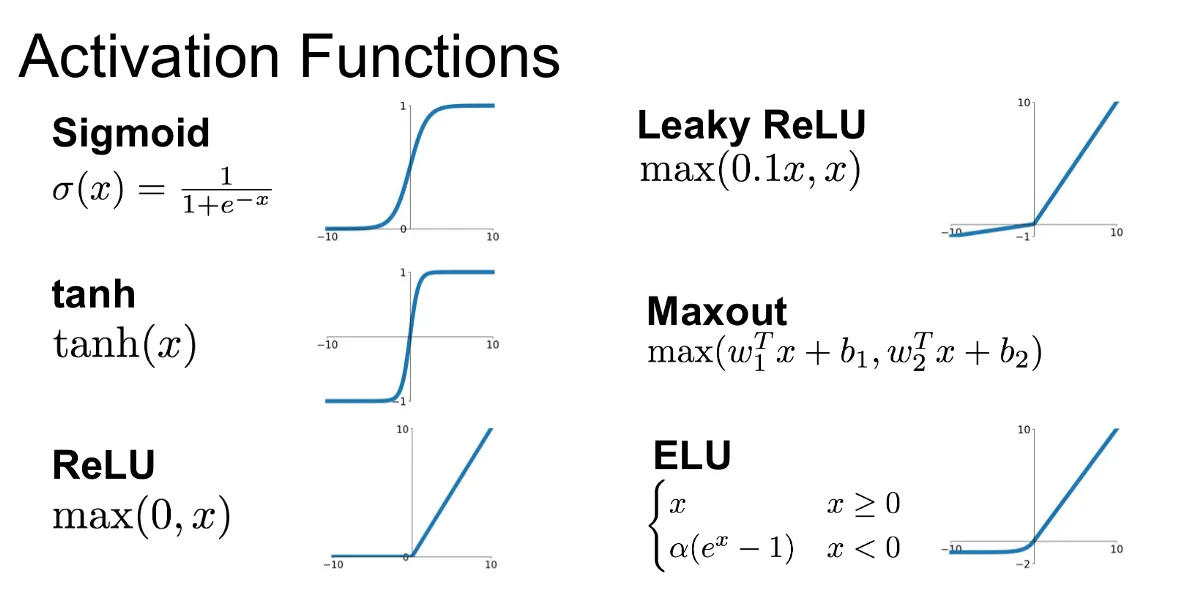

In [76]:
model = Sequential()
model.add(Dense(units = 500, 
                input_dim = 13,
                activation = 'tanh'))
# 과적합을 해결하고자 dropout
model.add(Dropout(0.1))
model.add(Dense(units = 200,
                activation = 'tanh'))
model.add(Dropout(0.1))
model.add(Dense(units = 100,
                activation = 'tanh'))
model.add(Dropout(0.1))
# 출력층에서의 활성화 함수: 
# Binary Classification(Logistic Regression)에서는 sigmoid
# Mulitnomial Classification에서는 softmax
model.add(Dense(units = 1, 
                activation = 'sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_14 (Dense)            (None, 500)               7000      
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dropout_9 (Dropout)         (None, 100)               0         
                                                                 
 dense_17 (Dense)            (None, 1)                

### 3. Training Process Setting (accuracy, precision, recall)


In [81]:
# Mulitnomial Classification(분류분석)일 때 성능평가지표
# accuracy(정확도)        :예측결과와 실제값이 동일한 건수 / 전체건수
# precision(정밀도, 민감도): 실제도 True인데 예측도 True로 맞춘 건수 / True로 예측한 건수
# recall(재현율)          : 실제도 True인데 예측도 True로 맞춘 건수 / 실제 True인 건수
model.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['accuracy', 
                         metrics.Recall(), 
                         metrics.Precision()]
              )

### 4. Training (train dataset의 일부를 validation dataset으로 학습)

In [82]:
hist = model.fit(X_train, y_train,
                 epochs = 100,
                 batch_size = 100, 
                 verbose = 1,
                 validation_split = 0.2 # test의 20%를 validation으로
                )

Epoch 1/100
2/2 [==============================] - 2s 367ms/step - loss: 0.6734 - accuracy: 0.5273 - recall_1: 0.6883 - precision: 0.4953 - val_loss: 0.5390 - val_accuracy: 0.7857 - val_recall_1: 0.7368 - val_precision: 0.7778
Epoch 2/100
2/2 [==============================] - 0s 57ms/step - loss: 0.5508 - accuracy: 0.7818 - recall_1: 0.8052 - precision: 0.7470 - val_loss: 0.4710 - val_accuracy: 0.7857 - val_recall_1: 0.8421 - val_precision: 0.7273
Epoch 3/100
2/2 [==============================] - 0s 57ms/step - loss: 0.4907 - accuracy: 0.8000 - recall_1: 0.8831 - precision: 0.7391 - val_loss: 0.4052 - val_accuracy: 0.8095 - val_recall_1: 0.7368 - val_precision: 0.8235
Epoch 4/100
2/2 [==============================] - 0s 55ms/step - loss: 0.4623 - accuracy: 0.8000 - recall_1: 0.7922 - precision: 0.7821 - val_loss: 0.3776 - val_accuracy: 0.8095 - val_recall_1: 0.6842 - val_precision: 0.8667
Epoch 5/100
2/2 [==============================] - 0s 49ms/step - loss: 0.4328 - accuracy: 0.81

2/2 [==============================] - 0s 55ms/step - loss: 0.3710 - accuracy: 0.8364 - recall_1: 0.8312 - precision: 0.8205 - val_loss: 0.3791 - val_accuracy: 0.8333 - val_recall_1: 0.7895 - val_precision: 0.8333
Epoch 38/100
2/2 [==============================] - 0s 44ms/step - loss: 0.3676 - accuracy: 0.8424 - recall_1: 0.8182 - precision: 0.8400 - val_loss: 0.3732 - val_accuracy: 0.8571 - val_recall_1: 0.7895 - val_precision: 0.8824
Epoch 39/100
2/2 [==============================] - 0s 50ms/step - loss: 0.3661 - accuracy: 0.8606 - recall_1: 0.8182 - precision: 0.8750 - val_loss: 0.3751 - val_accuracy: 0.8571 - val_recall_1: 0.7895 - val_precision: 0.8824
Epoch 40/100
2/2 [==============================] - 0s 28ms/step - loss: 0.3649 - accuracy: 0.8364 - recall_1: 0.7922 - precision: 0.8472 - val_loss: 0.3828 - val_accuracy: 0.8333 - val_recall_1: 0.8421 - val_precision: 0.8000
Epoch 41/100
2/2 [==============================] - 0s 49ms/step - loss: 0.3608 - accuracy: 0.8606 - reca

2/2 [==============================] - 0s 29ms/step - loss: 0.3187 - accuracy: 0.8485 - recall_1: 0.8052 - precision: 0.8611 - val_loss: 0.3727 - val_accuracy: 0.8810 - val_recall_1: 0.8421 - val_precision: 0.8889
Epoch 74/100
2/2 [==============================] - 0s 50ms/step - loss: 0.3044 - accuracy: 0.8788 - recall_1: 0.8312 - precision: 0.9014 - val_loss: 0.3753 - val_accuracy: 0.8571 - val_recall_1: 0.8421 - val_precision: 0.8421
Epoch 75/100
2/2 [==============================] - 0s 46ms/step - loss: 0.3034 - accuracy: 0.8606 - recall_1: 0.8182 - precision: 0.8750 - val_loss: 0.3826 - val_accuracy: 0.8571 - val_recall_1: 0.8421 - val_precision: 0.8421
Epoch 76/100
2/2 [==============================] - 0s 31ms/step - loss: 0.3041 - accuracy: 0.8667 - recall_1: 0.8701 - precision: 0.8481 - val_loss: 0.3899 - val_accuracy: 0.8571 - val_recall_1: 0.8421 - val_precision: 0.8421
Epoch 77/100
2/2 [==============================] - 0s 49ms/step - loss: 0.3073 - accuracy: 0.8727 - reca

### 5. Model 평가 
- 과정 살펴보기(그래프), evaluate, pd.crosstab/confusion_matrix(혼돈행렬)

In [83]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'recall_1', 'precision', 'val_loss', 'val_accuracy', 'val_recall_1', 'val_precision'])

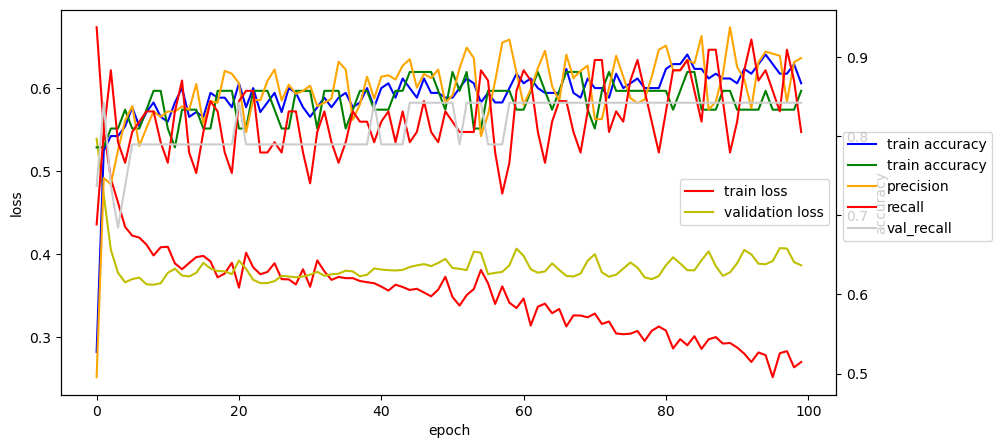

In [91]:
fig, loss_ax = plt.subplots(figsize=(10,5))
loss_ax.plot(hist.history['loss'], 'r', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'y', label='validation loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')

acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='train accuracy')
acc_ax.plot(hist.history['precision'], 'orange', label='precision')
acc_ax.plot(hist.history['recall_1'], 'r', label='recall')
acc_ax.plot(hist.history['val_recall_1'], '#cccccc', label='val_recall')

acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center right')
acc_ax.legend(bbox_to_anchor=(0.999, 0.7))
plt.show()

In [92]:
score = model.evaluate(X_test, y_test)
print('Model loss:', score[0])
print('Model accuracy:', score[1])
print('Model recall:', score[2])
print('Model precision:', score[3])

3/3 [==============================] - 0s 7ms/step - loss: 0.4117 - accuracy: 0.8090 - recall_1: 0.7750 - precision: 0.7949
Model loss: 0.4117007255554199
Model accuracy: 0.8089887499809265
Model recall: 0.7749999761581421
Model precision: 0.7948718070983887


In [106]:
# Confusion Matrix (매개변수에 2차원 데이터)
y_hat = (model.predict(X_test) > 0.5).astype(int)
print(y_hat.shape)
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
print(confusion_matrix(y_test, y_hat))
print('f1 score:', f1_score(y_test, y_hat))

3/3 [==============================] - 0s 0s/step
(89, 1)
[[41  8]
 [ 9 31]]
f1 score: 0.7848101265822786


In [ ]:
# Cross Tabulation (매개변수에 1차원 데이터)
pd.crosstab(y_test.values.reshape(-1), # 실제값(1차원) 
            y_hat.reshape(-1) # 예측값(1차원)    
           )

### 6. Model 사용